In [1]:
def RollingWindow(array, windows):
    n_iter = len(array) - windows - 1 
    newX = [array[i:(i+windows)] for i in range(n_iter)]
    newY = [array[i+windows] for i in range(n_iter)]
    return np.array(newX), np.array(newY)
def transformR(array):
    return np.log(array/array.shift(1))
def backwardR(arrayReturn, arrayPrice):
    return np.exp(arrayReturn) * arrayPrice.shift(1)
def plotter(y_true, y_pred, fname):
    plt.figure(figsize=(20, 6))
    plt.plot(y_true, color='#C5171C')
    plt.plot(y_pred, color='black', linewidth=2)
    plt.savefig(f'./Images/{fname}.png', bbox_inches='tight')

In [2]:
# import os
# os.path.abspath('.')

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# df = pd.read_csv('./Data/BTCUSDT-1h-data.csv')
# df = df.drop(["close_time", "quote_av","trades","tb_base_av","tb_quote_av","ignore"], axis=1)
# df.to_csv('./Data/CleanBTCUSDT-1h-data.csv', index=False)

In [4]:
# df = pd.read_csv('./Data/BTCUSDT_1M.csv')
# df = df.drop(["close_time", "quote_av","trades","tb_base_av","tb_quote_av","ignore"], axis=1)
# df.to_csv('./Data/CleanBTCUSDT_1M.csv', index=False)

In [9]:
# df = pd.read_csv('./Data/CleanBTCUSDT-1h-data.csv')
df = pd.read_csv('./Data/CleanBTCUSDT_1M.csv')

In [10]:
df = df[round(df.shape[0]/1.2):]

In [11]:
df.reset_index(drop=True, inplace=True)

In [12]:
df

timestamp      open      high       low     close     volume
0       2021-04-02 20:39:00  58783.79  58866.29  58783.79  58812.15  24.874955
1       2021-04-02 20:40:00  58812.15  58818.36  58770.01  58785.09  26.010284
2       2021-04-02 20:41:00  58785.08  58814.57  58774.18  58793.62  12.881304
3       2021-04-02 20:42:00  58793.61  58799.99  58757.57  58779.10  18.302502
4       2021-04-02 20:43:00  58779.12  58790.02  58764.19  58779.53  19.366303
...                     ...       ...       ...       ...       ...        ...
379975  2021-12-23 07:18:00  48399.24  48407.98  48384.86  48390.19  16.975530
379976  2021-12-23 07:19:00  48390.20  48417.98  48390.19  48417.98   9.188340
379977  2021-12-23 07:20:00  48417.97  48439.82  48406.19  48430.60   7.366720
379978  2021-12-23 07:21:00  48430.61  48442.00  48419.95  48425.96   6.630590
379979  2021-12-23 07:22:00  48425.97  48450.00  48421.11  48437.57   6.360080

[379980 rows x 6 columns]

<AxesSubplot:>

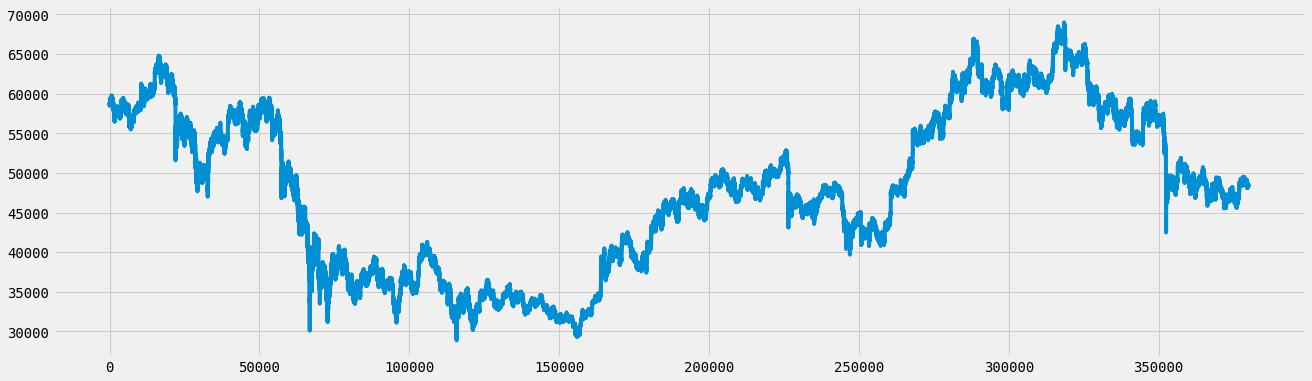

In [13]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["font.family"] = ["monospace"]

plt.figure(figsize=(20, 6))
df.close.plot()

In [14]:
close = df.close
closeR = transformR(close)[1:]
closeR.shape

(379979,)

<AxesSubplot:>

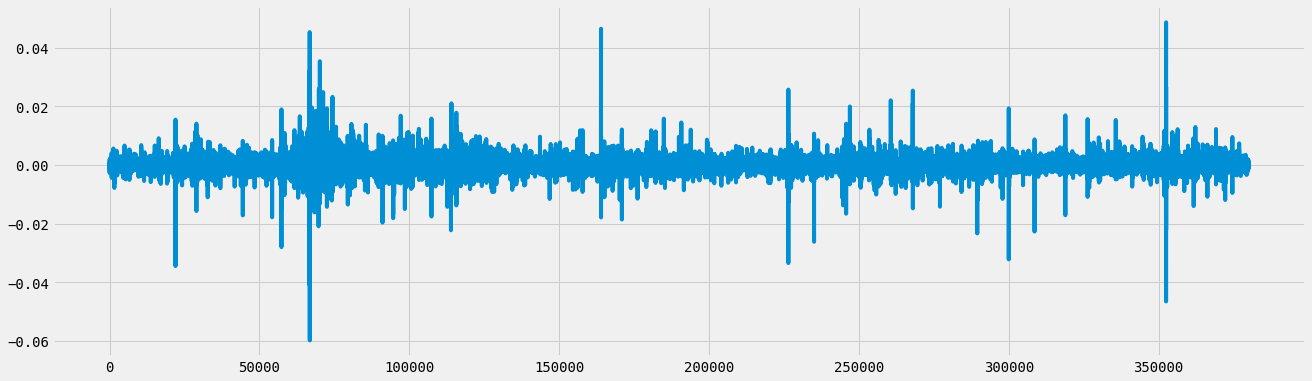

In [15]:
plt.figure(figsize=(20, 6))

closeR.plot()

In [16]:
pd.DataFrame(
    {
        'True': df.close.values,
        'Backward': backwardR(transformR(df.close), df.close).values
    }
)

True  Backward
0       58812.15       NaN
1       58785.09  58785.09
2       58793.62  58793.62
3       58779.10  58779.10
4       58779.53  58779.53
...          ...       ...
379975  48390.19  48390.19
379976  48417.98  48417.98
379977  48430.60  48430.60
379978  48425.96  48425.96
379979  48437.57  48437.57

[379980 rows x 2 columns]

In [17]:
windows = 10
zoom = 200
x, y = RollingWindow(closeR, windows)

In [18]:
(x.shape, y.shape)

((379968, 10), (379968,))

In [19]:
outputs = {}

In [22]:
mse = {}

# **Train-Test-Split**

In [20]:
pct = 0.7
TrainSize = round(y.shape[0]*pct)
TestSize = y.shape[0] - TrainSize

(TrainSize, TestSize)

(265978, 113990)

In [21]:
X_train, y_train = x[:TrainSize], y[:TrainSize]
X_test, y_test = x[TrainSize:], y[TrainSize:]

# **Train**

## **RandomForest**

In [23]:
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(n_estimators=100, criterion = 'squared_error')
RF.fit(X_train, y_train)
RF_pred = RF.predict(x)

In [24]:
RF_price = []
for i in range(len(x)):
    b = backwardR(RF_pred[i], df.close[windows+i:windows+i+3]).values
    RF_price.append(b[2])

In [25]:
RF_r2 = RF.score(X_test, y_test)
RF_mse = mean_squared_error(df.close[windows+1:-1], RF_price)

print(f'R2: {RF_r2}\nMSE: {RF_mse}')

R2: 0.99810970044479
MSE: 2984.209488439791


In [27]:
outputs['RF'] = RF_price
mse['RF'] = RF_mse

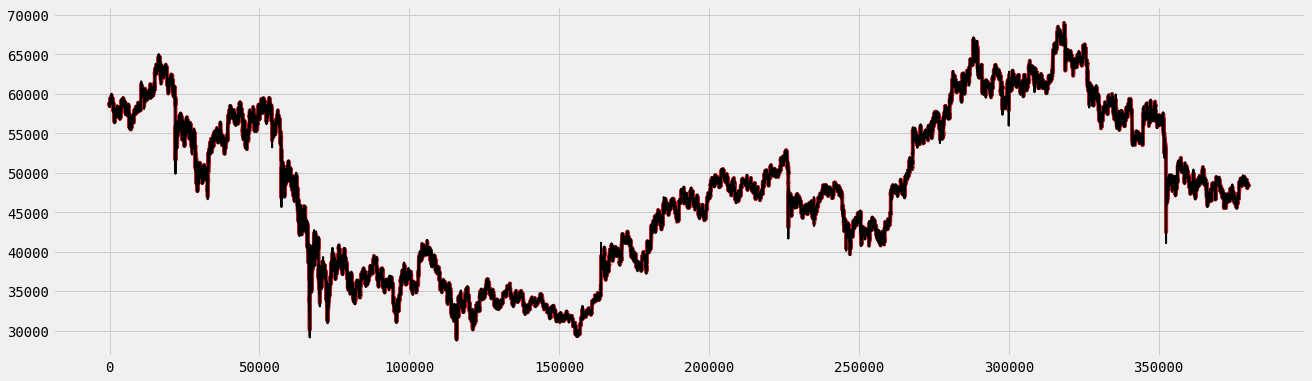

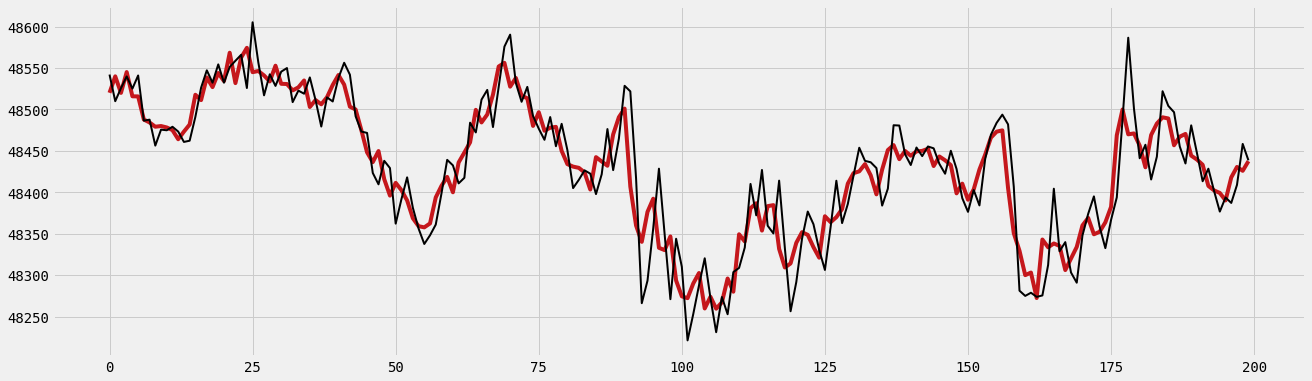

In [28]:
plotter(df.close.values, RF_price, 'RandomForestRegressor')
plotter(df.close.values[-zoom:], RF_price[-zoom:], 'RandomForestRegressor-Zoom')

## **KNN**

In [29]:
from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor(n_neighbors=3)
KNN.fit(X_train, y_train)
KNN_pred = KNN.predict(x)

In [31]:
KNN_r2 = KNN.score(X_test, y_test)
KNN_mse = mean_squared_error(df.close[windows+1:-1], KNN_price)

In [32]:
outputs['KNN'] = KNN_price
mse['KNN'] = KNN_mse

In [30]:
KNN_price = []
for i in range(len(x)):
    b = backwardR(KNN_pred[i], df.close[windows+i:windows+i+3]).values
    KNN_price.append(b[2])

In [33]:
print(f'R2: {KNN_r2}\nMSE: {KNN_mse}')

R2: 0.9035253900093282
MSE: 2268.5914267443495


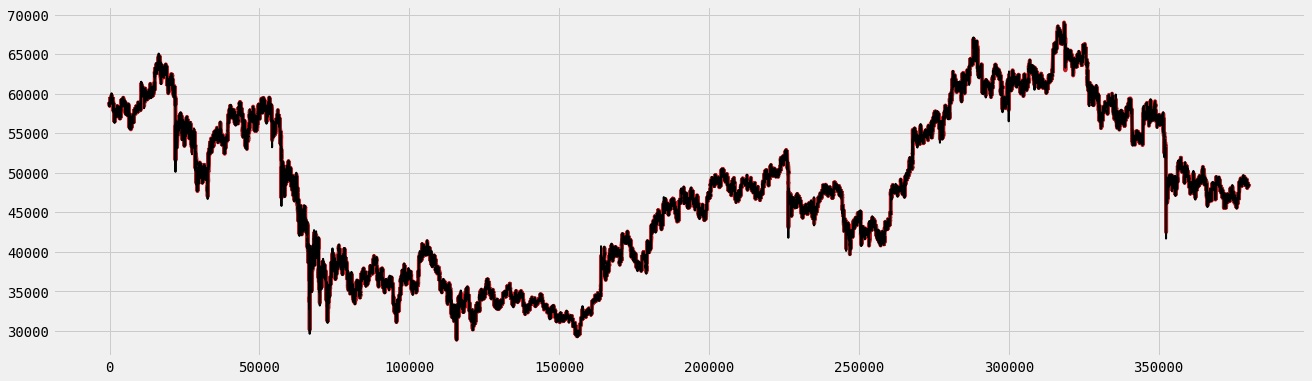

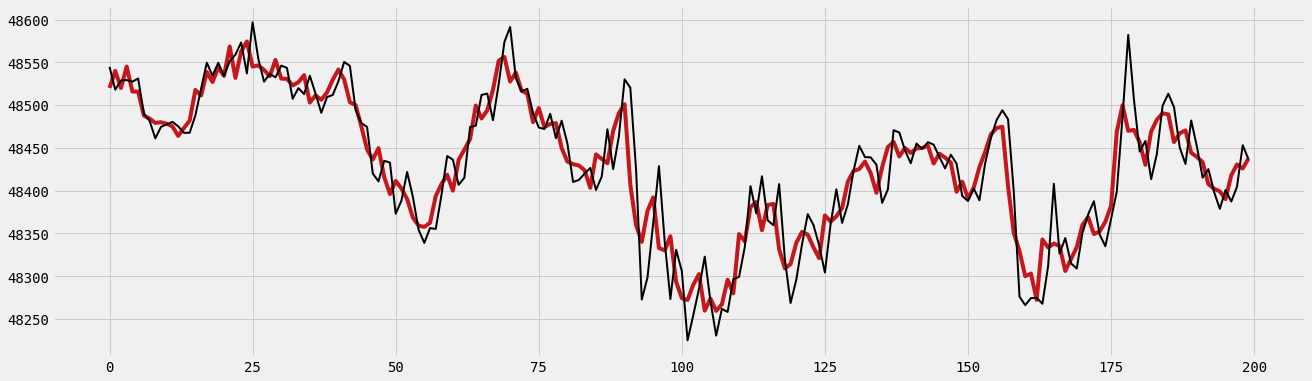

In [34]:
plotter(df.close.values, KNN_price, 'KNeighborsRegressor')
plotter(df.close.values[-zoom:], KNN_price[-zoom:], 'KNeighborsRegressor-Zoom')

## **xgboost**

```shell
conda install -c conda-forge xgboost
```

In [35]:
import xgboost as xgb

XGB = xgb.XGBRegressor()
XGB.fit(X_train, y_train)
XGB_pred = XGB.predict(x)

In [36]:
XGB_price = []
for i in range(len(x)):
    b = backwardR(XGB_pred[i], df.close[windows+i:windows+i+3]).values
    XGB_price.append(b[2])

In [37]:
XGB_mse = mean_squared_error(df.close[windows+1:-1], XGB_price)
XGB_r2 = XGB.score(X_test, y_test)

In [38]:
outputs['XGB'] = XGB_price
mse['XGB'] = XGB_mse

In [39]:
print(f'R2: {XGB_r2}\nMSE: {XGB_mse}')

R2: 0.9987494732902008
MSE: 2988.426373114397


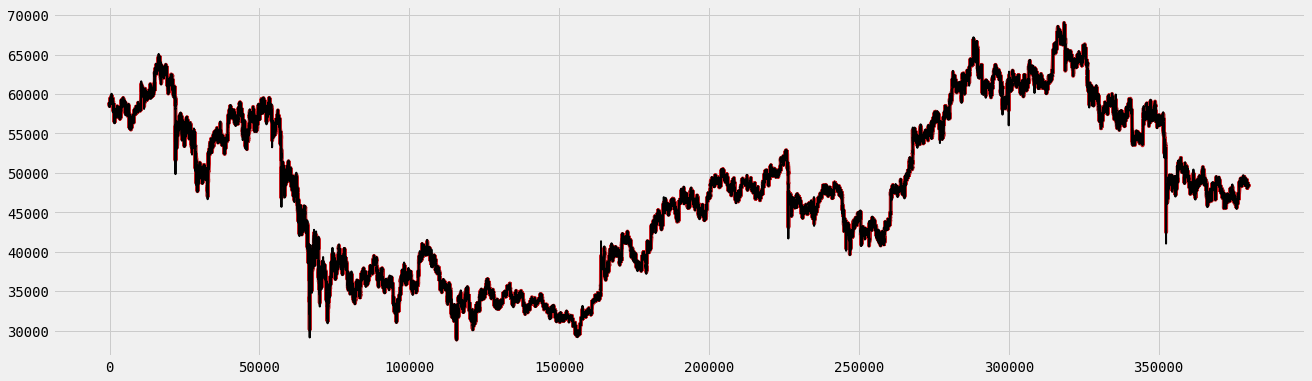

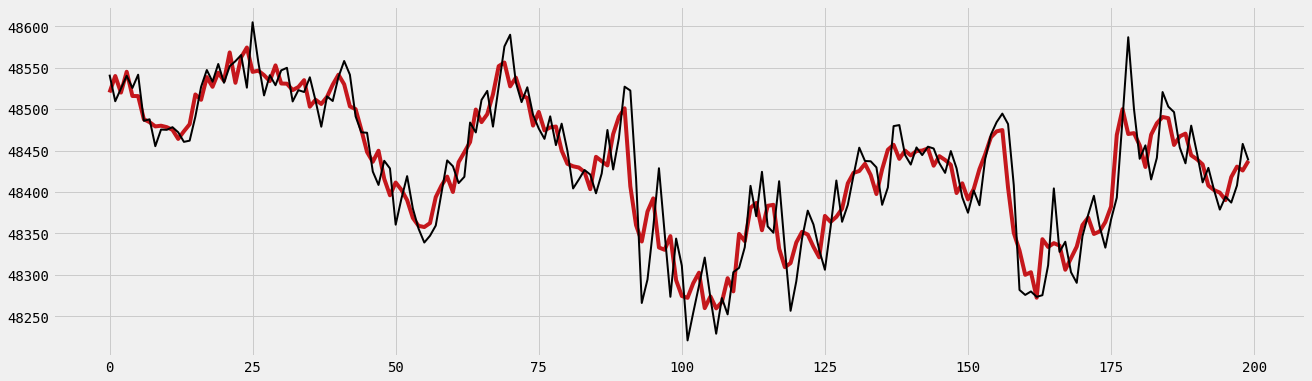

In [40]:
plotter(df.close.values, XGB_price, 'xgboost')
plotter(df.close.values[-zoom:], XGB_price[-zoom:], 'xgboost-Zoom')

In [46]:
outputs_df = pd.DataFrame(outputs)
mse_df = pd.DataFrame(mse, index=[0])

In [48]:
outputs_df.to_csv('./Data/ouputs_r.csv', index=False)
mse_df.to_csv('./Data/mse_r.csv', index=False)